In [ ]:
# Clustering algorithm k-means style of centroid initialization
# Yonghwan Kim A11746276 | Sangeon Park A11733433

# References:
# https://towardsdatascience.com/understanding-k-means-k-means-and-k-medoids-clustering-algorithms-ad9c9fbf47ca
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html#scipy.spatial.distance.cdist
# https://sparkbyexamples.com/apache-spark-rdd/spark-rdd-aggregate-example/
# https://numpy.org/doc/stable/reference/generated/numpy.amin.html
# https://numpy.org/doc/stable/reference/generated/numpy.argmin.html

In [ ]:
!pip install pyspark

In [ ]:
import sys
import re
 
from pyspark import SparkContext, SparkConf
from pyspark.sql import functions as f
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.spatial import distance
from operator import add

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# create Spark context with necessary configuration
sc = SparkContext("local","PySpark - CS5683 - project-3")

In [ ]:
# directory to project4
input_data = "/content/drive/MyDrive/data.txt"

In [ ]:
l=20
k=10
eu_cost_list = list()
mh_cost_list = list()

# split by enter which one row = one vector 
# split by space which is one coordinate. 58 coordinates = 1 vector address
readfile = np.loadtxt(input_data)
# remove duplicate rows
remove_duplicate = np.unique(readfile,axis=0)

# #read data
fileRDD = sc.parallelize(remove_duplicate)
# broadcasting the initial kmean centroid(10)
initial_centroid_broadcast = sc.broadcast(np.array(fileRDD.takeSample(False,k)))
np_vectorRDD = fileRDD.map(lambda vector: np.array([vector]).astype(np.float))


for i in range(l):
  # if the centroid is initial centroid
  if i == 0:
    # print("hit if : index is ",i)
    # this will return (index of mininum of eu_distance for each vector)  = very first cluster index = 1, very last cluter index = 10
    # note : np.argmin return the index of vector. That index will be represent closet cluster 1~10
    find_min_eu_distnaceRDD = np_vectorRDD.map(lambda vector : (np.argmin(distance.cdist(vector,np.array(initial_centroid_broadcast.value),'euclidean'))+1,vector))
    find_min_mh_distnaceRDD = np_vectorRDD.map(lambda vector : (np.argmin(distance.cdist(vector,np.array(initial_centroid_broadcast.value),'cityblock'))+1,vector))

    # find the minimum eu distance => square it => convert to np.float to float => add it all value = cost value of eu_distance
    eu_cost_functionRDD = np_vectorRDD.map(lambda vector :  np.amin(distance.cdist(vector,np.array(initial_centroid_broadcast.value),'euclidean'))).map(lambda min_eu_distance: np.square(min_eu_distance)).map(lambda min_eu_distance : float(min_eu_distance)).reduce(add)
    # find the minimum mh distance => convert to np.float to float => add it all value = cost value of eu_distance
    mh_cost_functionRDD = np_vectorRDD.map(lambda vector :  np.amin(distance.cdist(vector,np.array(initial_centroid_broadcast.value),'cityblock'))).map(lambda min_mh_distance : float(min_mh_distance)).reduce(add)

  # after program calculate new centriod not the initial centroid
  else:
    # print("hit else : index is ",i)
    # this will return (index of mininum of eu_distance for each vector)  = very first cluster index = 1, very last cluter index = 10
    # note : np.argmin return the index of vector. That index will be represent closet cluster 1~10
    find_min_eu_distnaceRDD = np_vectorRDD.map(lambda vector : (np.argmin(distance.cdist(vector,np.array(eu_centroid_broadcast.value),'euclidean'))+1,vector))
    find_min_mh_distnaceRDD = np_vectorRDD.map(lambda vector : (np.argmin(distance.cdist(vector,np.array(mh_centroid_broadcast.value),'cityblock'))+1,vector))
    # find the minimum eu distance => square it => convert to np.float to float => add it all value = cost value of eu_distance
    eu_cost_functionRDD = np_vectorRDD.map(lambda vector :  np.amin(distance.cdist(vector,np.array(eu_centroid_broadcast.value),'euclidean'))).map(lambda min_eu_distance: np.square(min_eu_distance)).map(lambda min_eu_distance : float(min_eu_distance)).reduce(add)
    # find the minimum mh distance => convert to np.float to float => add it all value = cost value of eu_distance
    mh_cost_functionRDD = np_vectorRDD.map(lambda vector :  np.amin(distance.cdist(vector,np.array(mh_centroid_broadcast.value),'cityblock'))).map(lambda min_mh_distance : float(min_mh_distance)).reduce(add)
  # append into eu_cost_list
  eu_cost_list.append(eu_cost_functionRDD)
  # now datapoints will groupby nearest cluster. This act represent the clustering.
  assign_into_clusterRDD = find_min_eu_distnaceRDD.groupByKey().map(lambda x : (x[0], list(x[1])))
  # find the average of the assigned datapoints's mean for each centroid. Average points for each centriod will be new centroid vector(58 coordinates)
  new_clusterRDD = assign_into_clusterRDD.map(lambda x : (x[0],np.mean(x[1],axis=0)))
  # sort by cluster number(1~10)
  new_clusterRDD_sorted = new_clusterRDD.sortBy(lambda x : x[0])
  # broadcast the new centroid point
  eu_centroid_broadcast = sc.broadcast(new_clusterRDD_sorted.map(lambda x: x[1][0]).collect())

  # append into eu_cost_list
  mh_cost_list.append(mh_cost_functionRDD)
  # now datapoints will groupby nearest centroid. This act represent the clustering.
  mh_assign_into_clusterRDD = find_min_mh_distnaceRDD.groupByKey().map(lambda x : (x[0], list(x[1])))
  # find the average of the assigned datapoints's mean for each centroid. Average points for each centriod will be new centroid vector(58 coordinates)
  mh_new_clusterRDD = mh_assign_into_clusterRDD.map(lambda x : (x[0],np.mean(x[1],axis=0)))
  # sort by cluster number(1~10)
  mh_new_clusterRDD_sorted = mh_new_clusterRDD.sortBy(lambda x : x[0])
  # broadcast the new centroid point
  mh_centroid_broadcast = sc.broadcast(mh_new_clusterRDD_sorted.map(lambda x: x[1][0]).collect())

# np_vectorRDD.collect()
print("initial_centroid : ")
print(initial_centroid_broadcast.value)
print("Updated centroid by using euclidean distance method")
print(eu_centroid_broadcast.value)
print("Updated centroid by using manhattan distance method")
print(mh_centroid_broadcast.value)
print("cost of euclidean distance : ")
print(eu_cost_list)
print("cost of manhattan distance : ")
print(mh_cost_list)

initial_centroid : 
[[0.000e+00 0.000e+00 2.150e+00 0.000e+00 1.070e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.070e+00 0.000e+00 1.070e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 1.920e-01 0.000e+00 0.000e+00 2.333e+00 1.900e+01
  4.900e+01 1.000e+00]
 [0.000e+00 6.300e-01 0.000e+00 0.000e+00 1.590e+00 3.100e-01 0.000e+00
  0.000e+00 3.100e-01 0.000e+00 0.000e+00 6.300e-01 0.000e+00 0.000e+00
  1.270e+00 6.300e-01 3.100e-01 3.180e+00 2.220e+00 0.000e+00 1.910e+00
  0.000e+00 3.100e-01 6.300e-01 0.000e+00 0.000e+00 0.000e+00 3.100e-01
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00

## initial_centroid : 
[[0.000e+00 0.000e+00 1.030e+00 0.000e+00 1.030e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 2.060e+00 1.030e+00 4.120e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 1.149e+00 0.000e+00 0.000e+00 1.461e+00 3.000e+00
  1.900e+01 1.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.700e-01 0.000e+00
  0.000e+00 0.000e+00 2.700e-01 0.000e+00 2.700e-01 0.000e+00 0.000e+00
  0.000e+00 2.700e-01 0.000e+00 0.000e+00 2.180e+00 0.000e+00 2.730e+00
  0.000e+00 0.000e+00 0.000e+00 2.700e-01 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 2.700e-01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.593e+00 1.800e+01
  1.660e+02 0.000e+00]
 [4.100e-01 0.000e+00 6.100e-01 0.000e+00 4.100e-01 6.100e-01 0.000e+00
  8.200e-01 2.000e-01 2.000e-01 2.000e-01 1.440e+00 0.000e+00 0.000e+00
  0.000e+00 4.100e-01 1.030e+00 2.000e-01 1.650e+00 1.650e+00 3.090e+00
  0.000e+00 2.000e-01 6.100e-01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  9.900e-02 0.000e+00 1.689e+00 1.320e-01 0.000e+00 4.913e+00 1.020e+02
  5.650e+02 1.000e+00]
 [0.000e+00 0.000e+00 5.900e-01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.900e-01 0.000e+00 0.000e+00 0.000e+00 2.990e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.190e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 1.190e+00 5.900e-01 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 5.900e-01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.910e-01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.836e+00 7.000e+00
  9.000e+01 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 6.000e-01 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 6.000e-01 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.010e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.800e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 6.000e-01 0.000e+00 6.000e-01 0.000e+00
  0.000e+00 6.000e-01 0.000e+00 6.000e-01 0.000e+00 0.000e+00 0.000e+00
  6.000e-01 0.000e+00 1.200e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.500e-02 8.500e-02 8.500e-02 0.000e+00 0.000e+00 1.735e+00 2.200e+01
  9.200e+01 0.000e+00]
 [0.000e+00 0.000e+00 8.000e-01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 8.000e-01 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 4.800e+00 0.000e+00 1.600e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 8.000e-01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00
  1.100e+01 0.000e+00]
 [1.300e-01 0.000e+00 2.000e-01 0.000e+00 5.400e-01 1.300e-01 0.000e+00
  1.300e-01 4.000e-01 0.000e+00 0.000e+00 6.000e-02 6.000e-02 0.000e+00
  0.000e+00 0.000e+00 1.010e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 1.080e+00 0.000e+00 0.000e+00 6.000e-02
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 4.000e-01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 6.000e-02 0.000e+00 0.000e+00 0.000e+00 9.000e-03
  6.800e-02 0.000e+00 0.000e+00 1.660e-01 0.000e+00 2.804e+00 4.500e+01
  6.170e+02 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 6.100e-01 6.100e-01 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 1.850e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 6.100e-01 0.000e+00 0.000e+00 6.100e-01 0.000e+00 0.000e+00
  6.100e-01 6.100e-01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 6.100e-01
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.790e-01
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.240e+00 6.000e+00
  6.700e+01 0.000e+00]
 [0.000e+00 0.000e+00 1.810e+00 0.000e+00 2.010e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 2.000e-01 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 4.000e-01 0.000e+00 2.000e-01 3.620e+00 0.000e+00 8.000e-01
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 4.000e-01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 3.010e-01 0.000e+00 0.000e+00 1.576e+00 1.700e+01
  1.640e+02 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 6.250e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 6.250e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 6.250e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 6.250e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.285e+00 3.000e+00
9.000e+00 0.000e+00]]


## Updated centroid by using euclidean distance method
[array([1.09708861e-01, 9.31898734e-02, 2.65367089e-01, 1.68354430e-03,
       2.13797468e-01, 6.48734177e-02, 1.22379747e-01, 7.51772152e-02,
       2.89240506e-02, 2.19151899e-01, 4.18227848e-02, 5.66392405e-01,
       8.81265823e-02, 3.11518987e-02, 2.36962025e-02, 2.26708861e-01,
       9.44303797e-02, 1.60126582e-01, 1.68792405e+00, 1.25822785e-02,
       6.88392405e-01, 0.00000000e+00, 4.67088608e-02, 5.23291139e-02,
       7.28594937e-01, 3.95088608e-01, 2.84000000e-01, 2.39784810e-01,
       1.37696203e-01, 1.94316456e-01, 1.14949367e-01, 7.98860759e-02,
       1.46481013e-01, 7.98860759e-02, 1.98405063e-01, 1.47556962e-01,
       2.14177215e-01, 5.78481013e-03, 1.61151899e-01, 8.97341772e-02,
       5.82911392e-02, 1.74139241e-01, 6.94556962e-02, 1.16746835e-01,
       3.20139241e-01, 2.44645570e-01, 2.37974684e-03, 3.53924051e-02,
       1.36379747e-02, 1.63277215e-01, 1.49632911e-02, 2.44053165e-01,
       4.97506329e-02, 4.25291139e-02, 2.24725316e+00, 1.10987342e+01,
       5.14151899e+01, 2.62025316e-01]), array([1.33096447e-01, 1.72842640e-01, 3.64568528e-01, 4.33705584e-01,
       2.93197970e-01, 1.27360406e-01, 8.10152284e-02, 1.46649746e-01,
       3.78172589e-01, 4.86903553e-01, 1.05634518e-01, 5.82182741e-01,
       1.23197970e-01, 9.36040609e-02, 1.39441624e-01, 2.53350254e-01,
       1.17258883e-01, 3.33857868e-01, 1.47030457e+00, 2.08883249e-01,
       1.06101523e+00, 8.06497462e-01, 1.45532995e-01, 1.66040609e-01,
       4.24822335e-01, 1.57512690e-01, 2.59898477e-02, 2.17258883e-02,
       6.75126904e-03, 2.31979695e-02, 2.42131980e-02, 1.42131980e-03,
       9.50761421e-02, 2.38578680e-03, 1.07157360e-01, 2.71065990e-02,
       1.31725888e-01, 2.84263959e-03, 2.37055838e-02, 2.92893401e-02,
       8.27411168e-03, 2.78172589e-02, 9.59390863e-03, 1.11167513e-02,
       3.76142132e-02, 3.58883249e-02, 8.93401015e-03, 3.02030457e-02,
       4.74517766e-02, 1.26842640e-01, 3.86192893e-02, 3.35076142e-01,
       1.56274112e-01, 9.67258883e-02, 7.88014213e+00, 1.35304569e+02,
       1.06268528e+03, 6.70050761e-01]), array([2.04728682e-01, 1.72790698e-01, 5.18062016e-01, 3.87596899e-02,
       4.47441860e-01, 2.36046512e-01, 1.23875969e-01, 1.83100775e-01,
       3.93333333e-01, 4.60775194e-01, 1.60852713e-01, 5.54728682e-01,
       2.07596899e-01, 2.48837209e-01, 3.72325581e-01, 3.08294574e-01,
       2.13953488e-01, 3.75271318e-01, 1.73511628e+00, 3.63178295e-01,
       9.02325581e-01, 2.55116279e-01, 3.96279070e-01, 2.37906977e-01,
       1.98139535e-01, 5.27906977e-02, 1.35658915e-02, 4.88372093e-03,
       1.31782946e-03, 1.24031008e-02, 2.79069767e-03, 0.00000000e+00,
       6.74418605e-02, 3.95348837e-03, 6.27906977e-03, 5.10077519e-02,
       1.01317829e-01, 4.18604651e-03, 8.29457364e-03, 3.89922481e-02,
       8.13953488e-03, 1.78294574e-03, 2.83720930e-02, 1.28682171e-02,
       4.32558140e-02, 5.11627907e-02, 1.39534884e-03, 1.80620155e-02,
       2.63333333e-02, 9.43178295e-02, 1.60310078e-02, 3.41558140e-01,
       2.31186047e-01, 7.03100775e-02, 5.96996977e+01, 4.70108527e+02,
       1.78475194e+03, 8.06201550e-01]), array([9.02759740e-02, 1.42905844e-01, 3.42548701e-01, 6.20129870e-02,
       4.39237013e-01, 1.58490260e-01, 1.84301948e-01, 1.29009740e-01,
       6.57142857e-02, 2.64204545e-01, 6.41396104e-02, 5.81964286e-01,
       1.12694805e-01, 2.46266234e-02, 4.44480519e-02, 2.90340909e-01,
       2.68360390e-01, 2.30730519e-01, 1.65004870e+00, 1.08652597e-01,
       1.06462662e+00, 3.04870130e-02, 1.54172078e-01, 9.13149351e-02,
       5.36298701e-01, 2.95146104e-01, 1.51720779e-01, 1.32954545e-01,
       7.67857143e-02, 1.15876623e-01, 5.52110390e-02, 4.40909091e-02,
       1.06931818e-01, 4.40909091e-02, 9.94480519e-02, 9.73214286e-02,
       1.80454545e-01, 6.60714286e-03, 8.14285714e-02, 8.04707792e-02,
       4.01461039e-02, 3.76298701e-02, 6.69318182e-02, 3.56493506e-02,
       1.77126623e-01, 9.84415584e-02, 5.09740260e-03, 2.11363636e-02,
       2.62987013e-02, 1.53801948e-01, 1.82613636e-02, 2.68074675e-01,
       8.32597403e-02, 2.77305195e-02, 3.55732143e+00, 3.70032468e+01,
       1.79586039e+02, 5.34090909e-01]), array([1.02209302e-01, 1.27767442e-01, 3.23720930e-01, 2.71488372e-01,
       3.72232558e-01, 1.22488372e-01, 1.99116279e-01, 1.45930233e-01,
       1.26395349e-01, 2.67302326e-01, 1.01023256e-01, 5.34883721e-01,
       9.98837209e-02, 3.46976744e-02, 3.10465116e-02, 2.70046512e-01,
       2.83372093e-01, 2.36372093e-01, 1.70197674e+00, 1.82465116e-01,
       9.81883721e-01, 4.85232558e-01, 1.52488372e-01, 9.95581395e-02,
       4.94930233e-01, 1.69883721e-01, 7.86046512e-02, 4.90930233e-02,
       3.97209302e-02, 4.65116279e-02, 3.76744186e-02, 1.87209302e-02,
       4.92093023e-02, 2.01627907e-02, 5.36976744e-02, 6.45116279e-02,
       1.50534884e-01, 1.22093023e-02, 3.75581395e-02, 6.35813953e-02,
       2.23488372e-02, 3.25813953e-02, 3.43488372e-02, 2.67906977e-02,
       1.33395349e-01, 1.50069767e-01, 8.79069767e-03, 2.77674419e-02,
       1.47972093e-01, 1.42437209e-01, 1.82302326e-02, 2.76906977e-01,
       1.15341860e-01, 9.16069767e-02, 6.63943721e+00, 6.59325581e+01,
       3.31574419e+02, 5.86046512e-01]), array([6.69949495e-02, 8.43181818e-02, 2.51944444e-01, 0.00000000e+00,
       2.74595960e-01, 4.47095960e-02, 3.45454545e-02, 5.96717172e-02,
       1.63257576e-02, 1.34987374e-01, 9.22979798e-03, 5.98813131e-01,
       5.78156566e-02, 6.71085859e-02, 2.97979798e-03, 1.72234848e-01,
       2.37247475e-02, 1.40896465e-01, 1.97950758e+00, 3.64015152e-02,
       5.27045455e-01, 0.00000000e+00, 1.11868687e-02, 5.61489899e-02,
       6.54318182e-01, 2.84255051e-01, 3.86679293e-01, 9.24242424e-02,
       2.23232323e-01, 1.11123737e-01, 8.95328283e-02, 5.38383838e-02,
       1.16325758e-01, 5.38383838e-02, 1.13712121e-01, 8.78030303e-02,
       7.52777778e-02, 3.57449495e-02, 8.73358586e-02, 5.93308081e-02,
       6.86111111e-02, 3.73787879e-01, 2.80555556e-02, 1.38699495e-01,
       7.74974747e-01, 3.18042929e-01, 6.42676768e-03, 4.96212121e-02,
       2.50606061e-02, 1.23546717e-01, 1.48876263e-02, 2.49775253e-01,
       1.18005051e-02, 7.31818182e-03, 1.64231818e+00, 4.70328283e+00,
       1.81616162e+01, 1.07323232e-01]), array([2.71875000e-01, 1.35208333e-01, 2.65625000e-01, 8.33333333e-04,
       7.83333333e-02, 1.00208333e-01, 1.72916667e-02, 1.38541667e-01,
       2.10416667e-01, 3.86041667e-01, 1.31458333e-01, 5.63125000e-01,
       2.98541667e-01, 5.68750000e-01, 2.89583333e-02, 1.48750000e-01,
       2.54375000e-01, 1.01666667e-01, 1.70875000e+00, 3.12500000e-02,
       8.05208333e-01, 2.31250000e-01, 4.34583333e-01, 2.53125000e-01,
       9.27083333e-02, 5.91666667e-02, 5.00000000e-03, 1.45833333e-03,
       2.08333333e-03, 3.75000000e-03, 0.00000000e+00, 0.00000000e+00,
       3.02916667e-01, 2.91666667e-03, 0.00000000e+00, 3.00000000e-02,
       1.71041667e-01, 1.45833333e-03, 8.12500000e-03, 1.68750000e-02,
       2.41666667e-02, 7.50000000e-03, 4.37500000e-03, 1.47916667e-02,
       3.89583333e-02, 5.56250000e-02, 7.91666667e-03, 4.91666667e-02,
       6.56250000e-02, 3.18750000e-01, 8.35416667e-03, 2.42750000e-01,
       3.52583333e-01, 1.16791667e-01, 1.07639583e+01, 3.98812500e+02,
       4.12197917e+03, 7.50000000e-01]), array([1.06684073e-01, 9.38642298e-02, 2.48968668e-01, 4.96083551e-03,
       3.69321149e-01, 8.27937337e-02, 1.39242820e-01, 1.27036554e-01,
       4.78067885e-02, 2.34647520e-01, 4.76109661e-02, 4.91710183e-01,
       9.05744125e-02, 4.12010444e-02, 2.66710183e-02, 3.23825065e-01,
       1.32402089e-01, 1.77036554e-01, 1.74339426e+00, 4.84334204e-02,
       7.85404700e-01, 2.29242820e-02, 8.55352480e-02, 6.99608355e-02,
       5.07885117e-01, 3.45953003e-01, 2.27127937e-01, 2.14399478e-01,
       7.63707572e-02, 1.17493473e-01, 6.10443864e-02, 6.02480418e-02,
       7.39425587e-02, 6.27806789e-02, 1.20731070e-01, 1.42349869e-01,
       1.39490862e-01, 4.81723238e-03, 1.02963446e-01, 5.84464752e-02,
       2.92297650e-02, 5.40731070e-02, 8.06919060e-02, 8.18798956e-02,
       2.76932115e-01, 1.98107050e-01, 6.57963446e-03, 3.24020888e-02,
       1.89046997e-02, 1.38898172e-01, 1.47506527e-02, 2.67699739e-01,
       5.72167102e-02, 5.39477807e-02, 2.82119713e+00, 2.09908616e+01,
       1.00131854e+02, 4.28198433e-01]), array([1.55427729e-01, 1.65722714e-01, 3.70501475e-01, 4.42772861e-02,
       3.44483776e-01, 1.26106195e-01, 9.42477876e-02, 1.45545723e-01,
       2.48259587e-01, 3.63952802e-01, 9.14749263e-02, 7.56548673e-01,
       1.26961652e-01, 1.09174041e-01, 8.69911504e-02, 2.56106195e-01,
       2.45014749e-01, 1.48790560e-01, 1.53752212e+00, 1.38436578e-01,
       1.08675516e+00, 3.12979351e-01, 1.50884956e-01, 1.66578171e-01,
       6.94808260e-01, 1.63952802e-01, 2.00884956e-02, 1.90265487e-02,
       1.21828909e-02, 2.25958702e-02, 1.09144543e-02, 5.04424779e-03,
       9.16814159e-02, 5.69321534e-03, 2.54572271e-02, 6.53097345e-02,
       1.33539823e-01, 1.28318584e-02, 1.79646018e-02, 2.00884956e-02,
       3.97345133e-02, 8.53392330e-02, 1.37758112e-02, 1.38938053e-02,
       5.52802360e-02, 1.27138643e-01, 9.17404130e-03, 2.04719764e-02,
       7.97433628e-02, 1.57699115e-01, 1.47404130e-02, 4.63380531e-01,
       1.45436578e-01, 6.45604720e-02, 7.33640118e+00, 9.78495575e+01,
       5.98817109e+02, 5.89970501e-01]), array([0.        , 0.        , 0.        , 0.        , 0.3268932 ,
       0.03339806, 0.        , 0.        , 0.        , 0.10786408,
       0.        , 0.22242718, 0.0538835 , 0.03339806, 0.        ,
       0.25679612, 0.        , 0.07466019, 1.28796117, 0.        ,
       0.35825243, 0.        , 0.        , 0.12135922, 0.40048544,
       0.21951456, 6.90533981, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.06067961, 0.        , 0.        ,
       0.        , 0.        , 0.08087379, 0.        , 0.        ,
       0.        , 0.47252427, 0.        , 0.4992233 , 0.66825243,
       0.15291262, 0.        , 0.11320388, 0.02172816, 0.10974757,
       0.03962136, 0.24161165, 0.        , 0.        , 1.21835922,
       1.73786408, 5.19417476, 0.05825243])]


## Updated centroid by using manhattan distance method
[array([1.02219140e-01, 8.86407767e-02, 2.38113731e-01, 1.87239945e-03,
       3.53190014e-01, 7.90291262e-02, 1.25603329e-01, 1.42135922e-01,
       5.07489598e-02, 2.31067961e-01, 4.69209431e-02, 4.90735090e-01,
       8.42579750e-02, 4.22468793e-02, 2.70457698e-02, 3.20457698e-01,
       1.34466019e-01, 1.74840499e-01, 1.71647712e+00, 4.88765603e-02,
       7.74549237e-01, 1.82524272e-02, 9.03328710e-02, 6.76005548e-02,
       5.03120666e-01, 3.44299584e-01, 2.19930652e-01, 2.20582524e-01,
       7.95006935e-02, 1.10041609e-01, 5.73786408e-02, 5.70735090e-02,
       7.04160888e-02, 5.83217753e-02, 1.25839112e-01, 1.40471567e-01,
       1.47101248e-01, 4.47988904e-03, 1.02316227e-01, 5.30929265e-02,
       2.94036061e-02, 5.82524272e-02, 8.39389736e-02, 8.36477115e-02,
       2.82981969e-01, 2.11123440e-01, 5.74202497e-03, 3.60332871e-02,
       1.77558946e-02, 1.39092926e-01, 1.51400832e-02, 2.53085992e-01,
       6.13384189e-02, 5.45894591e-02, 2.81454230e+00, 2.07337032e+01,
       9.77794730e+01, 4.24410541e-01]), array([1.32624113e-01, 1.55673759e-01, 5.00212766e-01, 2.03049645e-01,
       4.27943262e-01, 2.48794326e-01, 1.36524823e-01, 1.55815603e-01,
       3.65460993e-01, 4.42836879e-01, 1.27021277e-01, 5.66312057e-01,
       1.31914894e-01, 1.00567376e-01, 3.73404255e-01, 2.80851064e-01,
       1.47021277e-01, 3.99078014e-01, 1.50971631e+00, 4.10425532e-01,
       9.32056738e-01, 6.75319149e-01, 3.21631206e-01, 1.52482270e-01,
       1.91347518e-01, 8.45390071e-02, 2.21985816e-02, 1.15602837e-02,
       3.97163121e-03, 1.51063830e-02, 1.58865248e-02, 0.00000000e+00,
       4.41134752e-02, 9.21985816e-04, 4.91489362e-02, 3.85815603e-02,
       1.01276596e-01, 3.33333333e-03, 1.07092199e-02, 3.30496454e-02,
       4.60992908e-03, 1.21276596e-02, 2.92907801e-02, 1.31914894e-02,
       3.97872340e-02, 3.91489362e-02, 1.63120567e-03, 1.05673759e-02,
       2.69929078e-02, 1.12744681e-01, 2.45177305e-02, 3.10794326e-01,
       1.41184397e-01, 8.67872340e-02, 4.10065816e+01, 3.75943262e+02,
       1.39656028e+03, 7.44680851e-01]), array([1.10909091e-01, 3.63636364e-02, 1.86363636e-01, 3.63636364e-03,
       7.63636364e-02, 8.90909091e-02, 3.63636364e-03, 1.60000000e-01,
       8.18181818e-02, 2.07272727e-01, 7.09090909e-02, 1.94545455e-01,
       1.16363636e-01, 9.45454545e-02, 6.90909091e-02, 1.82727273e-01,
       1.24545455e-01, 1.02727273e-01, 9.70909091e-01, 8.18181818e-03,
       4.27272727e-01, 8.66363636e-01, 1.83636364e-01, 1.22727273e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.63636364e-02, 1.27272727e-02, 0.00000000e+00, 2.72727273e-02,
       5.45454545e-03, 0.00000000e+00, 7.27272727e-03, 3.09090909e-02,
       4.18181818e-02, 5.45454545e-03, 0.00000000e+00, 1.00000000e-02,
       4.00000000e-02, 7.45454545e-02, 2.72727273e-03, 2.45454545e-02,
       2.07000000e-01, 1.05727273e+00, 1.77272727e-02, 2.62090909e-01,
       3.89545455e-01, 2.05363636e-01, 2.88987273e+01, 1.13890909e+03,
       7.22690909e+03, 8.18181818e-01]), array([1.06769231e-01, 1.30461538e-01, 3.58487179e-01, 1.54358974e-01,
       4.15384615e-01, 1.15666667e-01, 1.94230769e-01, 1.75435897e-01,
       1.00589744e-01, 3.02410256e-01, 1.07538462e-01, 5.34923077e-01,
       1.13025641e-01, 3.61538462e-02, 4.54615385e-02, 3.07410256e-01,
       3.47538462e-01, 2.82153846e-01, 1.69489744e+00, 2.02435897e-01,
       1.08071795e+00, 4.04128205e-01, 1.65564103e-01, 9.34102564e-02,
       4.55025641e-01, 1.84282051e-01, 7.94871795e-02, 5.21538462e-02,
       4.69487179e-02, 5.38717949e-02, 3.21794872e-02, 2.15128205e-02,
       5.26410256e-02, 2.31025641e-02, 5.10769231e-02, 6.25641026e-02,
       1.59794872e-01, 6.66666667e-04, 3.42051282e-02, 5.01282051e-02,
       1.91794872e-02, 3.24871795e-02, 3.53589744e-02, 3.85897436e-02,
       1.35717949e-01, 1.52641026e-01, 7.43589744e-03, 2.70769231e-02,
       1.21546154e-01, 1.36525641e-01, 1.86538462e-02, 3.09369231e-01,
       1.24456410e-01, 9.26128205e-02, 6.43900513e+00, 6.33923077e+01,
       2.85425641e+02, 6.12820513e-01]), array([1.33323699e-01, 1.33063584e-01, 3.01734104e-01, 3.06965318e-01,
       3.55289017e-01, 1.31647399e-01, 1.33612717e-01, 1.28930636e-01,
       2.08236994e-01, 2.76994220e-01, 7.61271676e-02, 6.97080925e-01,
       1.05202312e-01, 4.92196532e-02, 4.07225434e-02, 2.62283237e-01,
       2.41560694e-01, 1.55231214e-01, 1.57300578e+00, 1.05664740e-01,
       9.39132948e-01, 4.40664740e-01, 1.50173410e-01, 1.33901734e-01,
       6.52572254e-01, 1.60115607e-01, 4.30057803e-02, 2.98554913e-02,
       2.32947977e-02, 2.64161850e-02, 2.31502890e-02, 8.69942197e-03,
       7.71965318e-02, 9.33526012e-03, 3.42774566e-02, 7.14450867e-02,
       1.35780347e-01, 2.46242775e-02, 3.10115607e-02, 5.23121387e-02,
       4.39595376e-02, 4.44219653e-02, 1.74566474e-02, 1.11271676e-02,
       7.92196532e-02, 1.38757225e-01, 9.94219653e-03, 2.17052023e-02,
       9.53757225e-02, 1.52447977e-01, 1.39913295e-02, 2.58673410e-01,
       9.87254335e-02, 7.07341040e-02, 6.57312139e+00, 7.24248555e+01,
       4.92861272e+02, 5.66473988e-01]), array([1.10879690e-01, 9.47218629e-02, 2.63492885e-01, 1.72056921e-03,
       2.23622251e-01, 6.32600259e-02, 1.28939198e-01, 7.47347995e-02,
       2.69210867e-02, 2.22677878e-01, 4.22639069e-02, 5.75627426e-01,
       8.94695990e-02, 3.37516171e-02, 2.24062096e-02, 2.15097025e-01,
       9.46830530e-02, 1.63738680e-01, 1.66743855e+00, 1.48641656e-02,
       6.92884864e-01, 0.00000000e+00, 4.73221216e-02, 5.25614489e-02,
       8.48020699e-01, 4.52794308e-01, 3.41423027e-01, 3.04126779e-01,
       1.98551100e-01, 2.54708926e-01, 1.75640362e-01, 1.38900388e-01,
       1.52082794e-01, 1.38900388e-01, 2.53169470e-01, 2.05640362e-01,
       2.19805951e-01, 6.50711514e-03, 1.63454075e-01, 1.48576973e-01,
       5.86287193e-02, 1.77335058e-01, 7.39586028e-02, 1.16597671e-01,
       3.00763260e-01, 2.42548512e-01, 2.27684347e-03, 3.79818887e-02,
       1.48926261e-02, 1.75627426e-01, 1.53091850e-02, 2.46510996e-01,
       5.11901682e-02, 4.49068564e-02, 2.27648124e+00, 1.11862872e+01,
       5.15756792e+01, 2.62613195e-01]), array([2.87058824e-01, 2.07058824e-01, 3.07176471e-01, 5.51764706e-02,
       1.92823529e-01, 9.08235294e-02, 3.10588235e-02, 1.40941176e-01,
       3.09294118e-01, 4.36352941e-01, 1.63529412e-01, 5.87411765e-01,
       3.26000000e-01, 6.14941176e-01, 6.71764706e-02, 2.04470588e-01,
       2.83294118e-01, 1.23647059e-01, 2.01129412e+00, 4.48235294e-02,
       9.25882353e-01, 4.90588235e-02, 4.16470588e-01, 3.07176471e-01,
       2.55411765e-01, 8.02352941e-02, 4.35294118e-03, 3.29411765e-03,
       2.47058824e-03, 6.00000000e-03, 0.00000000e+00, 0.00000000e+00,
       2.27294118e-01, 4.47058824e-03, 3.64705882e-03, 4.11764706e-02,
       1.68117647e-01, 2.11764706e-03, 8.00000000e-03, 2.72941176e-02,
       1.42352941e-02, 5.41176471e-03, 8.23529412e-03, 1.34117647e-02,
       4.68235294e-02, 4.80000000e-02, 4.94117647e-03, 4.18823529e-02,
       2.92235294e-02, 9.91411765e-02, 1.20000000e-02, 2.84564706e-01,
       3.49658824e-01, 8.78941176e-02, 3.14190706e+01, 2.93576471e+02,
       2.67623529e+03, 7.64705882e-01]), array([8.76804124e-02, 1.39725086e-01, 3.35103093e-01, 7.09621993e-03,
       4.05704467e-01, 1.60034364e-01, 1.88024055e-01, 1.08213058e-01,
       5.81443299e-02, 2.50360825e-01, 6.33848797e-02, 5.53659794e-01,
       1.08367698e-01, 2.14776632e-02, 3.74742268e-02, 2.94810997e-01,
       2.26907216e-01, 2.01529210e-01, 1.66195876e+00, 9.91065292e-02,
       1.02249141e+00, 3.59621993e-02, 1.40532646e-01, 9.58934708e-02,
       5.63883162e-01, 3.16752577e-01, 1.63144330e-01, 1.42182131e-01,
       7.64261168e-02, 1.28316151e-01, 6.01546392e-02, 4.89175258e-02,
       1.12731959e-01, 5.07044674e-02, 1.09295533e-01, 1.02852234e-01,
       1.72869416e-01, 6.87285223e-03, 8.70446735e-02, 7.98109966e-02,
       4.24398625e-02, 3.46907216e-02, 6.62371134e-02, 3.28522337e-02,
       1.93797251e-01, 1.03831615e-01, 5.39518900e-03, 2.10309278e-02,
       2.74725086e-02, 1.58020619e-01, 1.80395189e-02, 2.71134021e-01,
       7.40257732e-02, 2.66786942e-02, 3.45394158e+00, 3.36426117e+01,
       1.68104811e+02, 5.15463918e-01]), array([1.57984190e-01, 1.99802372e-01, 4.18023715e-01, 2.33122530e-01,
       3.32608696e-01, 1.28300395e-01, 8.46640316e-02, 1.64071146e-01,
       3.59169960e-01, 4.98893281e-01, 1.07035573e-01, 6.83201581e-01,
       1.48142292e-01, 1.33675889e-01, 1.45019763e-01, 2.32213439e-01,
       1.60671937e-01, 2.80988142e-01, 1.56861660e+00, 1.86442688e-01,
       1.17573123e+00, 3.98774704e-01, 1.38853755e-01, 1.94110672e-01,
       5.50276680e-01, 1.52845850e-01, 2.53754941e-02, 1.96837945e-02,
       7.70750988e-03, 2.47430830e-02, 1.69960474e-02, 2.80632411e-03,
       1.00513834e-01, 3.55731225e-03, 6.99604743e-02, 3.86166008e-02,
       1.19525692e-01, 5.57312253e-03, 2.02371542e-02, 3.19367589e-02,
       8.97233202e-03, 8.68774704e-02, 1.40711462e-02, 1.15810277e-02,
       3.95256917e-02, 3.34782609e-02, 8.65612648e-03, 2.73122530e-02,
       7.48735178e-02, 1.36806324e-01, 2.90197628e-02, 5.72422925e-01,
       1.95059289e-01, 6.34466403e-02, 7.48545850e+00, 1.27458498e+02,
       8.55584980e+02, 6.52173913e-01]), array([6.26431718e-02, 7.53414097e-02, 2.29129956e-01, 0.00000000e+00,
       2.85594714e-01, 4.51541850e-02, 3.25770925e-02, 4.53744493e-02,
       1.61013216e-02, 1.31718062e-01, 8.05066079e-03, 5.54977974e-01,
       5.79295154e-02, 6.19052863e-02, 2.59911894e-03, 1.88700441e-01,
       2.17951542e-02, 1.34350220e-01, 1.92061674e+00, 3.17511013e-02,
       5.09284141e-01, 0.00000000e+00, 6.26651982e-03, 6.27422907e-02,
       5.27433921e-01, 2.29845815e-01, 1.08345815e+00, 2.95814978e-02,
       1.42973568e-01, 5.17070485e-02, 3.11343612e-02, 0.00000000e+00,
       1.08348018e-01, 0.00000000e+00, 5.22246696e-02, 3.31607930e-02,
       6.53193833e-02, 4.03524229e-02, 7.88986784e-02, 5.89207048e-03,
       6.15969163e-02, 3.79262115e-01, 2.29845815e-02, 1.81134361e-01,
       7.68766520e-01, 2.98127753e-01, 6.72907489e-03, 5.33039648e-02,
       2.40980176e-02, 1.12192731e-01, 1.73733480e-02, 2.49870044e-01,
       8.10572687e-03, 5.06277533e-03, 1.56083040e+00, 4.20044053e+00,
       1.70396476e+01, 1.00220264e-01])]


##cost of euclidean distance : 
[1299558790.1116629, 866786252.2469591, 726211990.9306176, 666396155.6773365, 597881331.079079, 547672581.2678252, 528073346.36290497, 513014394.91810733, 498245547.72540534, 487612844.9019434, 479761397.4946043, 473862799.790809, 469830913.384395, 466132955.84283304, 463077584.9588529, 461249671.85003334, 460149891.1881191, 458973745.8291913, 458255411.3162949, 457823016.025572]

##cost of manhattan distance : 

[765857.9190000002, 642922.8111379457, 580929.8321334142, 551432.8115587245, 500820.631842789, 503785.3153288486, 505000.3312772524, 504203.38773800636, 501063.30122927384, 492261.4916026245, 485429.83995337685, 479298.27021765016, 476608.60188268364, 475021.2944079038, 472319.8367424439, 466427.7443407062, 465169.07550832053, 464404.56235990685, 457544.326643552, 447210.37208426156]

In [ ]:
print(type(eu_cost_list))

<class 'list'>


In [ ]:
xpoint= np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
# input
eu_ypoint = np.array(eu_cost_list)
def percentage_change(first, tenth):
  return (first-tenth)/first
# text component of Percentage change between first and tenth cost
firstandtenth = 'Percentage change between first and tenth cost : %.2f'%(percentage_change(eu_ypoint[0],eu_ypoint[9])*100)+" %"

#set the graph size
fig = plt.figure(figsize=(10, 5))
# scale setting
ax = fig.add_axes([0, 0, 1, 1])
# title
ax.set_title('k-mean : Euclidean distance cost', fontsize=24, fontweight='bold')
# show exact number of what xpoint have
ax.set_xticks(xpoint) 
# x label
ax.set_xlabel('iteration', fontsize=18, fontweight='bold')
# y label
ax.set_ylabel('Euclidean Cost', fontsize=18, fontweight='bold')
# plot
ax.plot([xpoint],[eu_ypoint],'ro')
# legend
ax.legend(['Euclidean'])
fig.text(0.5,0.6,firstandtenth,horizontalalignment='center',verticalalignment='center',fontsize=12,fontweight='bold')
# annotation for first iteration cost and tenth iteration cost
for i,j in zip(xpoint,eu_ypoint):
    if i%5==0 or i== 1:
      new_j = "{:.2f}".format(j)
      ax.annotate(new_j,xy=(i,j),xytext=(i,j+j*0.02),horizontalalignment='center',verticalalignment='center')
    if i == 1:    
      ax.annotate('first iteration cost',xy=(i,j),xytext=(i+3,j*0.9),arrowprops=dict(facecolor='black', shrink=0.05),fontsize=10,fontweight='bold')
    if i == 10:
      ax.annotate('tenth iteration cost',xy=(i,j),xytext=(i+3,j*1.1),arrowprops=dict(facecolor='black', shrink=0.05),fontsize=10,fontweight='bold')

plt.show()

In [ ]:
xpoint= np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
# input
mh_ypoint = np.array(mh_cost_list)
def percentage_change(first, tenth):
  return (first-tenth)/first
# text component of Percentage change between first and tenth cost
firstandtenth = 'Percentage change between first and tenth cost : %.2f'%(percentage_change(mh_ypoint[0],mh_ypoint[9])*100)+" %"

#set the graph size
fig = plt.figure(figsize=(10, 5))
# scale setting
ax = fig.add_axes([0, 0, 1, 1])
# title
ax.set_title('k-mean : Manhattan distance cost', fontsize=24, fontweight='bold')
# show exact number of what xpoint have
ax.set_xticks(xpoint) 
# x label
ax.set_xlabel('iteration', fontsize=18, fontweight='bold')
# y label
ax.set_ylabel('Manhattan Cost', fontsize=18, fontweight='bold')
# plot
ax.plot([xpoint],[mh_ypoint],'bo')
# legend
ax.legend(['Manhattan'])
fig.text(0.5,0.6,firstandtenth,horizontalalignment='center',verticalalignment='center',fontsize=12,fontweight='bold')
# annotation for first iteration cost and tenth iteration cost
for i,j in zip(xpoint,mh_ypoint):
    if i%5==0 or i== 1:
      new_j = "{:.2f}".format(j)
      ax.annotate(new_j,xy=(i,j),xytext=(i,j),horizontalalignment='center',verticalalignment='center')
    if i == 1:    
      ax.annotate('first iteration cost',xy=(i,j),xytext=(i+3,j*0.9),arrowprops=dict(facecolor='black', shrink=0.05),fontsize=10,fontweight='bold')
    if i == 10:
      ax.annotate('tenth iteration cost',xy=(i,j),xytext=(i+3,j*1.1),arrowprops=dict(facecolor='black', shrink=0.05),fontsize=10,fontweight='bold')

plt.show()

K-mean is the algorithms that pick random k datapoints as initial centroid. This is because initial cost is higher than K-mean++ algorithms. 

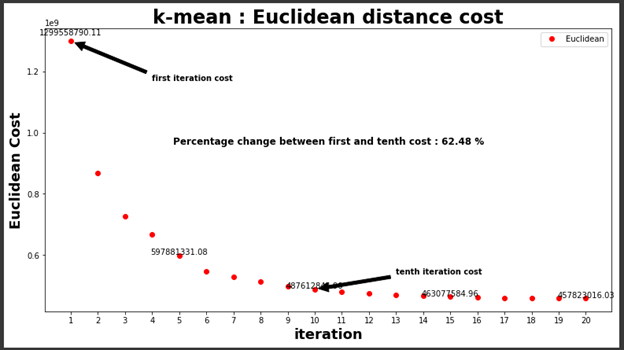

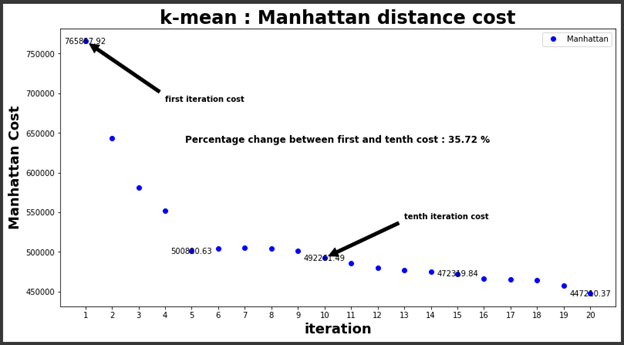

As you know the euclidean distance formula is that square is include in the equation. Moreover, there is another square in the equation when trying to find euclidean cost. This is because euclidean cost is higher than manhattan cost. Every iteration, cost is drop rapidly and after iteration 10, cost is try to converage to speific points. 

As you see the manhattan distance equation, there is no square for cost or find the distance. Comparing to euclidean distance, cost is lower than euclidean cost. However, the perchange change of first and tenth iteration is lower than euclidean distance cost. 

As you comparing between manhattan and euclidean distance cost, The euclidean distance cost itself is higer than manhattan distance cost.
However, As you see the percentage change difference between manhattan and euclidean distance cost, euclidean cost difference is more rapid than manhattan distance cost.
Thus, euclidean distance cost takes more cost but fast convergence.

In [ ]:
######### this is my other teammate code(k-mean ++) to compare the performance between kmean and kmean++####################################################

In [ ]:
import random
import os
import numpy as np
import re
import math
from random import randrange
from shutil import copyfile
from collections import defaultdict

import pandas as pd
import matplotlib.pyplot as plt

import sys
from itertools import chain, combinations # iteration tool

from pyspark import SparkContext, SparkConf

from pyspark.sql import functions as f
from scipy.spatial import distance
from operator import add

In [ ]:
# the number of clusters(k)
k = 10
# the number of algorithm interations (I)
iter = 20

In [ ]:
dir = "/content/drive/MyDrive/data.txt"

# data = open(dir, 'r')
# fileRDD = sc.parallelize(data)
mat = np.loadtxt(dir)
num_rows, num_cols = mat.shape # mat.shape[0] mat.shape[1]
print(num_rows, num_cols)
uniqueMat = np.unique(mat, axis=0)
num_unique_rows, num_unique_cols = uniqueMat.shape 
print(num_unique_rows, num_unique_cols)
rdd = sc.parallelize(uniqueMat)
# rdd.saveAsTextFile("uniquemat")
# rdd = sc.textFile(dir)
irdd = rdd.zipWithIndex()
irdd = irdd.map(lambda x: (x[1] , x[0]))
irdd.persist()

4601 58
4210 58


PythonRDD[244] at RDD at PythonRDD.scala:53

In [ ]:
# datapoint based comparing with centroids
# def squaredEuclideanDistance(x, centroids):
#     distance = []
#     for m in centroids:
#         if m[0] != x[0]:
#             value = np.sum((x[1] - m[1]) ** 2)
#             distance.append(value)
#     if distance:
#         maxUclid = max(distance)
#         # maxUclid = max(distance, key = lambda k: k[0])
#         return maxUclid
#     else:
#         return None

# centroids based comparing with each datapoints
def squaredEuclideanDistance(x, m):
    value = np.sum((x - m) ** 2)
    return value

centroids = []

# Test case when initial datapoint is 899
# testlist = irdd.collect()
# for ts in testlist:
#     if ts[0] == 4063:
#         centroids.append(ts)

# Actual Case
firstCentroid = irdd.takeSample(False, 1)
centroids.append(firstCentroid[0])

print("first random Centroid",centroids[0][0])
 
while len(centroids) != k:
    # datapoint based comparing with centroids
    # nextCentroid = irdd.map(lambda x: (x[0], squaredEuclideanDistance(x, centroids)))
    # resultCent = nextCentroid.collect()
    # removalList = []
    # for r in resultCent:
    #     for c in centroids:
    #         if c[0] == r[0]:
    #             # print("Equal detected.", r, c[0], r[0])
    #             removalList.append(r)
    # resultSetCent = set(resultCent)
    # removalSet = set(removalList)
    # centRemoved = resultSetCent.difference(removalSet)
    # minCent = min(centRemoved, key = lambda t: t[1])

    # centroids based comparing with each datapoints
    recomList = []
    # print("cent: ", len(centroids))
    for c in centroids:
        nextCentroid = irdd.map(lambda x: (x[0], squaredEuclideanDistance(x[1], c[1])))
        nextCentroidRT = nextCentroid.collect()
        for rc in centroids:
            for nc in nextCentroidRT:
                if rc[0] == nc[0]:
                    nextCentroidRT.remove(nc)
        maxCent = max(nextCentroidRT, key=lambda x: x[1])
        recomList.append(maxCent)
    print("recm: ", recomList)
    minCent = min(recomList, key = lambda t: t[1])


    
    # print(minCent)
    nn = irdd.filter(lambda x: x[0] == minCent[0])
    centroids.append((minCent[0], nn.collect()[0][1]))
print("------------------------------------------------------------------------------------------------")
for c in centroids:
    print(c[0])

clusters = []
clusterIndex = 1

for centroid in centroids:
    clusters.append((clusterIndex, centroid[1]))
    # clusters.append(centroid[1])
    clusterIndex = clusterIndex + 1
# for c in clusters:
#     print(c)

# euclidean_centroids = sc.broadcast(clusters)
# manhattan_centroids = sc.broadcast(clusters)

euclidean_centroids = sc.broadcast(clusters)
manhattan_centroids = sc.broadcast(clusters)


# for t in centroidsBC.value:
#     print(t[0], t[1])
# # using min() and max()
# to get min and max in list of tuples
# res1 = min(test_list)[0], max(test_list)[0]
# res2 = min(test_list)[1], max(test_list)[1]

# testlist = rdd.takeSample(False,k)
# cclusters = []
# cclusterIndex = 1

# for centroid in testlist:
#     cclusters.append((cclusterIndex, centroid))
#     # clusters.append(centroid[1])
#     cclusterIndex = cclusterIndex + 1
# centroidsBC = sc.broadcast(cclusters)

first random Centroid 2152
recm:  [(3555, 237437609.308892)]
recm:  [(1988, 191795100.076301), (390, 250906104.826198)]
recm:  [(3674, 77511954.273927), (390, 250906104.826198), (390, 201040987.830523)]
recm:  [(2120, 74974356.189814), (390, 250906104.826198), (390, 201040987.830523), (390, 85311470.969579)]
recm:  [(2119, 74939729.651947), (390, 250906104.826198), (390, 201040987.830523), (390, 85311470.969579), (390, 82633674.153522)]
recm:  [(93, 29922058.972063), (390, 250906104.826198), (390, 201040987.830523), (390, 85311470.969579), (390, 82633674.153522), (390, 82597323.933433)]
recm:  [(3229, 24633223.178073), (390, 250906104.826198), (390, 201040987.830523), (390, 85311470.969579), (390, 82633674.153522), (390, 82597323.933433), (390, 34821923.163105)]
recm:  [(3907, 13825270.23593), (390, 250906104.826198), (390, 201040987.830523), (390, 85311470.969579), (390, 82633674.153522), (390, 82597323.933433), (390, 34821923.163105), (390, 29101900.520399)]
recm:  [(1646, 11079541.7

In [ ]:
def euclideanDistance(M1, centroids):
    candidates = []
    for m in centroids:
        # value = np.sum(np.square(np.subtract(M1, m[1])))
        value = np.sum((M1 - m[1]) ** 2)
        sqED = math.sqrt(value)
        candidates.append((m[0], sqED))
    # centroid = np.argmin(candidates)
    centroid = min(candidates, key = lambda k: k[1])
    return centroid

def manhattanDistance(M1, centroids):
    candidates = []
    for m in centroids:
        value = np.sum(np.absolute(M1 - m[1]))
        candidates.append((m[0], value))
    centroid = min(candidates, key = lambda k: k[1])
    return centroid

def findCentroid(data):
    a = np.array(data)
    mean = np.mean(a, axis=0)
    # lengthData = len(data)
    # nextCentroid = np.zeros(58)
    # for d in data:
    #     value = np.add(nextCentroid, d[1])
    # nextCentroid = value/lengthData
    return mean

euclidList = []
manhattonList = []

euclidCostFuncList = []
manhattonCostFuncList = []

for i in range(iter):
    # euclidRDD = irdd.map(lambda x: (euclideanDistance(x[1], euclidean_centroids.value)[0], x[1]))
    # manhattanRDD = irdd.map(lambda x: (manhattanDistance(x[1], manhattan_centroids.value)[0], x[1]))
    euclidRDD = irdd.map(lambda x: (euclideanDistance(x[1], euclidean_centroids.value), x[1]))
    manhattanRDD = irdd.map(lambda x: (manhattanDistance(x[1], manhattan_centroids.value), x[1]))
    
    # euclidCostFunc = euclidRDD.map(lambda x: (x[0][1]) ** 2).map(lambda x : float(x)).reduce(add)
    # manhattanCostFunc = manhattanRDD.map(lambda x : float(x[0][1])).reduce(add)
    euclidCostFunc = euclidRDD.map(lambda x: (x[0][1]) ** 2).reduce(add)
    manhattanCostFunc = manhattanRDD.map(lambda x : x[0][1]).reduce(add)
    euclidCostFuncList.append(euclidCostFunc)
    manhattonCostFuncList.append(manhattanCostFunc)
    # print(euclidCostFunc)
    # print(manhattanCostFunc)
    euclidNextRDD = euclidRDD.map(lambda x: (x[0][0], x[1]))
    manhattanNextRDD = manhattanRDD.map(lambda x: (x[0][0], x[1]))

    # euclidean
    euclidTestRDD = euclidNextRDD.groupByKey().map(lambda x : (x[0], len(list(x[1]))))
    euclidGroupRDD = euclidNextRDD.groupByKey().map(lambda x : (x[0], list(x[1])))
    # print("Euclidean: ", sorted(euclidTestRDD.collect()))
    euclidList.append(sorted(euclidTestRDD.collect()))
    nextEuclidClusters = euclidGroupRDD.map(lambda x: (x[0], findCentroid(x[1]))).sortBy(lambda x : x[0])

    euclidean_centroids = sc.broadcast(nextEuclidClusters.collect())

    # manhattan
    manhattanTestRDD = manhattanNextRDD.groupByKey().map(lambda x : (x[0], len(list(x[1]))))
    manhattanGroupRDD = manhattanNextRDD.groupByKey().map(lambda x : (x[0], list(x[1])))
    # print("Manhattan: ", sorted(manhattanTestRDD.collect()))
    manhattonList.append(sorted(manhattanTestRDD.collect()))
    nextManhattanClusters = manhattanGroupRDD.map(lambda x: (x[0], findCentroid(x[1]))).sortBy(lambda x : x[0])

    manhattan_centroids = sc.broadcast(nextManhattanClusters.collect())

print("Euclidean")
for e in euclidList:
    print(e)
print("Manhattan")
for m in manhattonList:
    print(m)

print("Euclidean cost")
for e in euclidCostFuncList:
    print(e)
print("Manhattan cost")
for m in manhattonCostFuncList:
    print(m)

Euclidean
[(1, 4127), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 75)]
[(1, 4079), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 4), (10, 120)]
[(1, 4010), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 31), (10, 162)]
[(1, 3923), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 46), (10, 234)]
[(1, 3835), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 58), (10, 310)]
[(1, 3784), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 75), (10, 344)]
[(1, 3738), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 83), (10, 382)]
[(1, 3704), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 85), (10, 413)]
[(1, 3679), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 2), (9, 85), (10, 437)]
[(1, 3659), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 8), (9, 79), (10, 457)]
[(1, 3653), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 27), (9, 62), (10, 461)]
[(1, 3641), (2, 1), (3, 

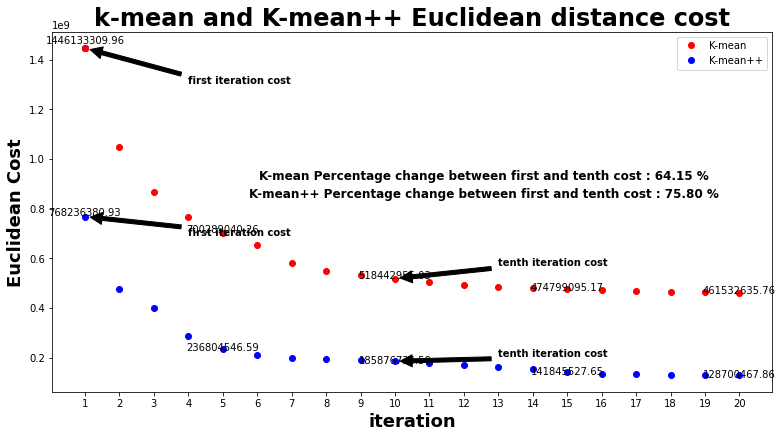

In [ ]:

xpoint= np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
k_eu_ypoint = np.array(eu_cost_list)
kp_eu_ypoint = np.array(euclidCostFuncList)
def percentage_change(first, tenth):
  return (first-tenth)/first
k_firstandtenth = 'K-mean Percentage change between first and tenth cost : %.2f'%(percentage_change(k_eu_ypoint[0],k_eu_ypoint[9])*100)+" %"
kp_firstandtenth = 'K-mean++ Percentage change between first and tenth cost : %.2f'%(percentage_change(kp_eu_ypoint[0],kp_eu_ypoint[9])*100)+" %"


#set the graph size
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_title('k-mean and K-mean++ Euclidean distance cost', fontsize=24, fontweight='bold')
# show exact number of what xpoint have
ax.set_xticks(xpoint) 
ax.set_xlabel('iteration', fontsize=18, fontweight='bold')
ax.set_ylabel('Euclidean Cost', fontsize=18, fontweight='bold')

ax.plot([xpoint[0]],[k_eu_ypoint[0]],'ro',label='K-mean')
ax.plot([xpoint[0]],[k_eu_ypoint[0]],'bo',label='K-mean++')
ax.legend()
justk = ax.plot([xpoint],[k_eu_ypoint],'ro',label='K-mean')
k__=ax.plot([xpoint],[kp_eu_ypoint],'bo',label='K-mean++')

# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fig.text(0.6,0.6,k_firstandtenth,horizontalalignment='center',verticalalignment='center',fontsize=12,fontweight='bold')
fig.text(0.6,0.55,kp_firstandtenth,horizontalalignment='center',verticalalignment='center',fontsize=12,fontweight='bold')

for i,j in zip(xpoint,k_eu_ypoint):
    if i%5==0 or i== 1:
      new_j = "{:.2f}".format(j)
      ax.annotate(new_j,xy=(i,j),xytext=(i,j+j*0.02),horizontalalignment='center',verticalalignment='center')
    if i == 1:    
      ax.annotate('first iteration cost',xy=(i,j),xytext=(i+3,j*0.9),arrowprops=dict(facecolor='black', shrink=0.05),fontsize=10,fontweight='bold')
    if i == 10:
      ax.annotate('tenth iteration cost',xy=(i,j),xytext=(i+3,j*1.1),arrowprops=dict(facecolor='black', shrink=0.05),fontsize=10,fontweight='bold')
for i,j in zip(xpoint,kp_eu_ypoint):
    if i%5==0 or i== 1:
      new_j = "{:.2f}".format(j)
      ax.annotate(new_j,xy=(i,j),xytext=(i,j+j*0.02),horizontalalignment='center',verticalalignment='center')
    if i == 1:    
      ax.annotate('first iteration cost',xy=(i,j),xytext=(i+3,j*0.9),arrowprops=dict(facecolor='black', shrink=0.05),fontsize=10,fontweight='bold')
    if i == 10:
      ax.annotate('tenth iteration cost',xy=(i,j),xytext=(i+3,j*1.1),arrowprops=dict(facecolor='black', shrink=0.05),fontsize=10,fontweight='bold')
plt.show()

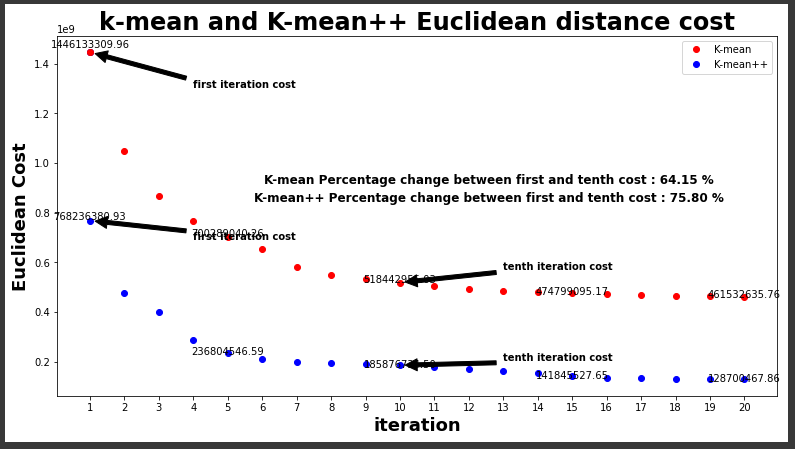

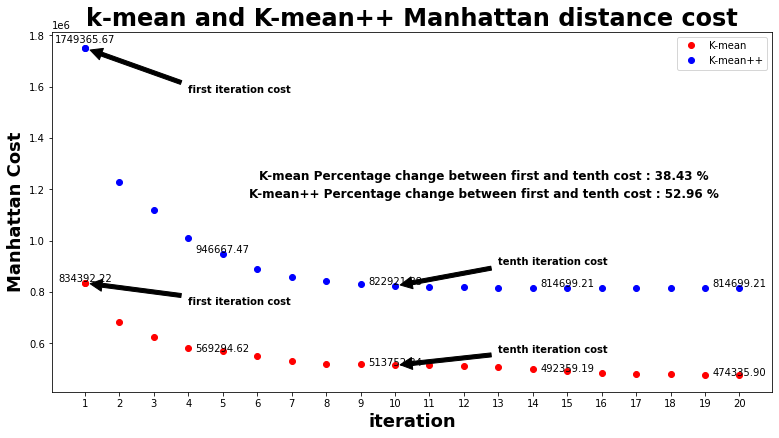

In [ ]:

xpoint= np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
k_mh_ypoint = np.array(mh_cost_list)
kp_mh_ypoint = np.array(manhattonCostFuncList)
def percentage_change(first, tenth):
  return (first-tenth)/first
k_firstandtenth = 'K-mean Percentage change between first and tenth cost : %.2f'%(percentage_change(k_mh_ypoint[0],k_mh_ypoint[9])*100)+" %"
kp_firstandtenth = 'K-mean++ Percentage change between first and tenth cost : %.2f'%(percentage_change(kp_mh_ypoint[0],kp_mh_ypoint[9])*100)+" %"


#set the graph size
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_title('k-mean and K-mean++ Manhattan distance cost', fontsize=24, fontweight='bold')
# show exact number of what xpoint have
ax.set_xticks(xpoint) 
ax.set_xlabel('iteration', fontsize=18, fontweight='bold')
ax.set_ylabel('Manhattan Cost', fontsize=18, fontweight='bold')

ax.plot([xpoint[0]],[k_mh_ypoint[0]],'ro',label='K-mean')
ax.plot([xpoint[0]],[kp_mh_ypoint[0]],'bo',label='K-mean++')
ax.legend()
justk = ax.plot([xpoint],[k_mh_ypoint],'ro',label='K-mean')
k__=ax.plot([xpoint],[kp_mh_ypoint],'bo',label='K-mean++')

# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fig.text(0.6,0.6,k_firstandtenth,horizontalalignment='center',verticalalignment='center',fontsize=12,fontweight='bold')
fig.text(0.6,0.55,kp_firstandtenth,horizontalalignment='center',verticalalignment='center',fontsize=12,fontweight='bold')

for i,j in zip(xpoint,k_mh_ypoint):
    if i%5==0 or i== 1:
      new_j = "{:.2f}".format(j)
      ax.annotate(new_j,xy=(i,j),xytext=(i,j+j*0.02),horizontalalignment='center',verticalalignment='center')
    if i == 1:    
      ax.annotate('first iteration cost',xy=(i,j),xytext=(i+3,j*0.9),arrowprops=dict(facecolor='black', shrink=0.05),fontsize=10,fontweight='bold')
    if i == 10:
      ax.annotate('tenth iteration cost',xy=(i,j),xytext=(i+3,j*1.1),arrowprops=dict(facecolor='black', shrink=0.05),fontsize=10,fontweight='bold')
for i,j in zip(xpoint,kp_mh_ypoint):
    if i%5==0 or i== 1:
      new_j = "{:.2f}".format(j)
      ax.annotate(new_j,xy=(i,j),xytext=(i,j+j*0.02),horizontalalignment='center',verticalalignment='center')
    if i == 1:    
      ax.annotate('first iteration cost',xy=(i,j),xytext=(i+3,j*0.9),arrowprops=dict(facecolor='black', shrink=0.05),fontsize=10,fontweight='bold')
    if i == 10:
      ax.annotate('tenth iteration cost',xy=(i,j),xytext=(i+3,j*1.1),arrowprops=dict(facecolor='black', shrink=0.05),fontsize=10,fontweight='bold')
plt.show()

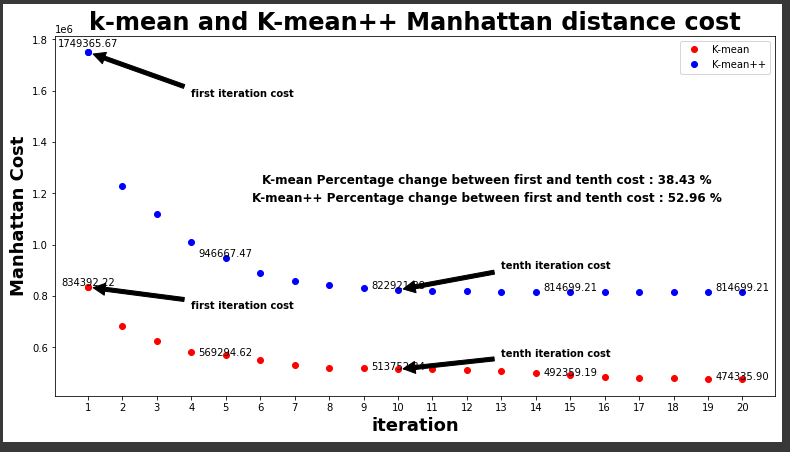

In [ ]:
sc.stop()